# Projet : Chasseur d’Aurores Boréales

# L’objectif est de suivre, visualiser et prédire les aurores boréales à partir de mesures solaires (flux, éruptions, indice géomagnétique, etc.)

Ce qu'on a fait: 

Créé un pipeline temps réel avec plusieurs API NOAA

Fait des visualisations dynamiques et explicatives

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
# Configuration matplotlib
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('seaborn-v0_8-darkgrid')

Les 5 endpoints NOAA qui te permettent d’accéder à différentes mesures :

Indice K (Boulder) → mesure de l’activité géomagnétique sur Terre

OVATION Aurora Map → prédiction de probabilité d’aurores

Événements solaires → éruptions, tempêtes, etc.

Flux solaire F10.7 → intensité du rayonnement solaire

Cycle solaire → informations sur les cycles à long terme

In [3]:
# --- 2. Chargement des sources NOAA
URLS = {
    "boulder_k_index": "https://services.swpc.noaa.gov/json/boulder_k_index_1m.json",
    "aurora_ovation": "https://services.swpc.noaa.gov/json/ovation_aurora_latest.json",
    "edited_events": "https://services.swpc.noaa.gov/json/edited_events.json",
    "solar_flux": "https://services.swpc.noaa.gov/json/f107_cm_flux.json",
    "solar_cycle": "https://services.swpc.noaa.gov/json/solar-cycle/",
}


Télécharger et parser proprement les fichiers JSON.
Elle nous permet de ne pas dupliquer le code à chaque appel d’API.

In [4]:
# --- 3. Fonction générique de téléchargement
def load_json(url):
    print(f"🔹 Chargement de {url} ...")
    r = requests.get(url)
    r.raise_for_status()
    return r.json()

Les données de l’indice K, qui mesure l’activité géomagnétique de la Terre.

Cet indice est crucial :

Quand K ≥ 5, il y a forte probabilité d’aurores visibles dans les hautes latitudes.

In [ ]:
# --- 4. Indice K de Boulder (corrigé)
k_data = load_json(URLS["boulder_k_index"])
df_k = pd.DataFrame(k_data)

print("\nColonnes disponibles :", df_k.columns.tolist())
print(df_k.head(3))

# Détection automatique de la colonne K
possible_k_cols = [c for c in df_k.columns if 'k' in c.lower() and 'index' in c.lower()]
if possible_k_cols:
    k_col = possible_k_cols[0]
    print(f"✅ Colonne d'indice K détectée : {k_col}")
else:
    raise ValueError("Impossible de trouver la colonne du K-index dans les données NOAA")

# Conversion du temps pour avoir une série temporelle bien ordonnée.
if "time_tag" in df_k.columns:
    df_k["time_tag"] = pd.to_datetime(df_k["time_tag"])
elif "time_tag_str" in df_k.columns:
    df_k["time_tag"] = pd.to_datetime(df_k["time_tag_str"])
else:
    raise ValueError("Impossible de trouver la colonne temporelle dans les données NOAA")

df_k = df_k.sort_values("time_tag")


🔹 Chargement de https://services.swpc.noaa.gov/json/boulder_k_index_1m.json ...

Colonnes disponibles : ['time_tag', 'k_index']
              time_tag  k_index
0  2025-10-22T11:34:00      1.0
1  2025-10-22T11:35:00      1.0
2  2025-10-22T11:36:00      1.0
✅ Colonne d'indice K détectée : k_index


Tu affiches une courbe temporelle de l’activité géomagnétique, avec une ligne rouge à K=5 comme seuil d’alerte d’aurores.

Cela te permet d’observer en temps réel les variations de l’activité magnétique terrestre.

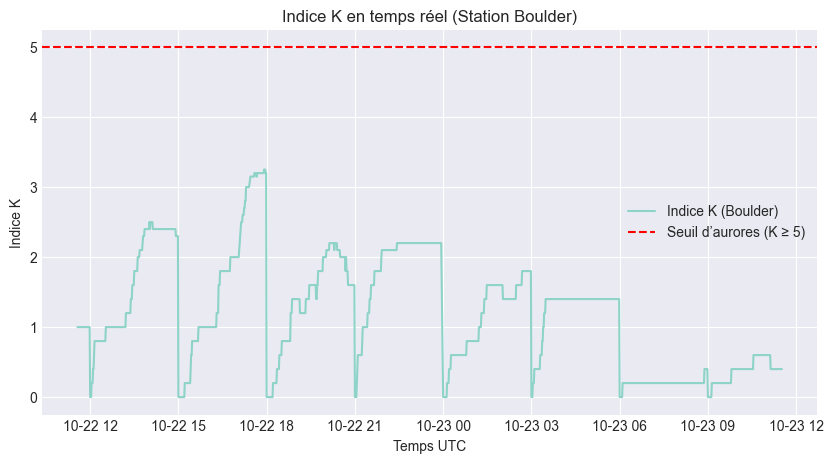

In [8]:
# --- 5. Visualisation de l'indice K
plt.figure()
plt.plot(df_k["time_tag"], df_k[k_col], label="Indice K (Boulder)")
plt.axhline(5, color='r', linestyle='--', label="Seuil d’aurores (K ≥ 5)")
plt.title("Indice K en temps réel (Station Boulder)")
plt.xlabel("Temps UTC")
plt.ylabel("Indice K")
plt.legend()
plt.show()

Récupéré les coordonnées latitude/longitude et probabilité d’aurore depuis le modèle OVATION de la NOAA.

Puis visualisés une carte en scatter plot, colorée selon la probabilité.
C’est une carte thermique des aurores boréales en direct, actualisée par la NOAA.

🔹 Chargement de https://services.swpc.noaa.gov/json/ovation_aurora_latest.json ...

✅ Données de carte d’aurores chargées : (65160, 3)
   lat  lon  prob
0    0  -90     5
1    0  -89     0
2    0  -88     7
3    0  -87     7
4    0  -86     7


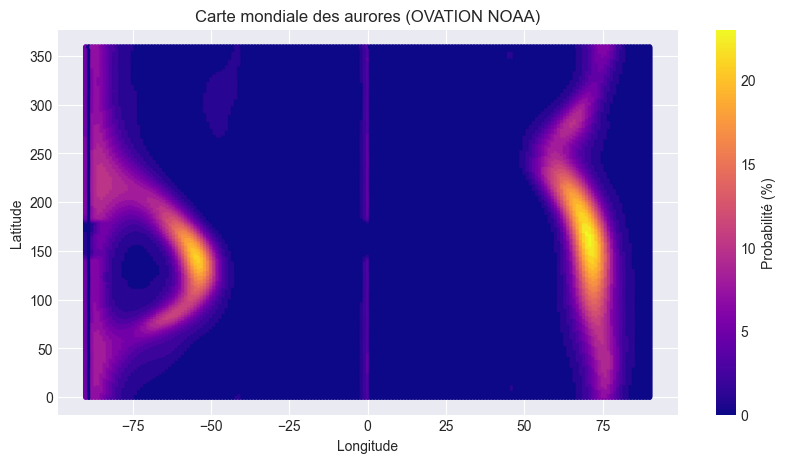

In [10]:
# --- 6. Carte mondiale des aurores (OVATION)
aurora_data = load_json(URLS["aurora_ovation"])
coords = aurora_data.get("coordinates", [])
if not coords:
    print("⚠️ Aucune coordonnée trouvée dans les données OVATION.")
else:
    df_aurora = pd.DataFrame(coords, columns=["lat", "lon", "prob"])
    print("\n✅ Données de carte d’aurores chargées :", df_aurora.shape)
    print(df_aurora.head())

    plt.figure()
    plt.scatter(df_aurora["lon"], df_aurora["lat"],
                c=df_aurora["prob"], cmap="plasma", s=10)
    plt.colorbar(label="Probabilité (%)")
    plt.title("Carte mondiale des aurores (OVATION NOAA)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

Charger les événements comme :

Éruptions solaires (flares)

Éjections de masse coronale (CME)

Taches solaires, etc.

Cela permettra plus tard de corréler les éruptions avec les pics d’aurores.

In [11]:
# --- 7. Événements solaires récents
events_data = load_json(URLS["edited_events"])
df_events = pd.DataFrame(events_data)
print("✅ Événements solaires :", df_events.shape)
display(df_events.head())



🔹 Chargement de https://services.swpc.noaa.gov/json/edited_events.json ...
✅ Événements solaires : (1841, 29)


,begin_datetime,begin_quality,max_datetime,max_quality,end_datetime,end_quality,observatory,quality,type,coded_type,...,particulars7,particulars8,particulars9,particulars10,region,bin,age,status_code,status_text,change_flag
0,2025-10-23T08:41:00,,2025-10-23T08:54:00,,2025-10-23T08:59:00,,G18,5,XRA,1,...,None,None,None,1.5E-06,NaN,1380,None,4,+,0
1,2025-10-23T08:41:00,,2025-10-23T08:54:00,,2025-10-23T08:59:00,,G19,5,XRA,1,...,None,None,None,1.5E-06,NaN,1380,None,2,-,0
2,2025-10-23T04:56:00,,2025-10-23T05:08:00,,2025-10-23T05:15:00,,G19,5,XRA,1,...,None,None,None,3.2E-06,NaN,1370,None,2,-,0
3,2025-10-23T04:56:00,,2025-10-23T05:08:00,,2025-10-23T05:15:00,,G18,5,XRA,1,...,None,None,None,3.2E-06,NaN,1370,None,4,+,0
4,2025-10-23T04:11:00,,2025-10-23T04:24:00,,2025-10-23T04:29:00,,G18,5,XRA,1,...,None,None,None,2.0E-06,NaN,1360,None,4,+,0


Analyses des flux radio solaire (mesuré en sfu = solar flux unit).
C’est un indicateur de l’activité solaire globale, souvent lié aux perturbations géomagnétiques.

Crées une courbe temporelle du flux, pour suivre les variations du Soleil.

🔹 Chargement de https://services.swpc.noaa.gov/json/f107_cm_flux.json ...

Colonnes flux solaire : ['time_tag', 'frequency', 'flux', 'reporting_schedule', 'avg_begin_date', 'ninety_day_mean', 'rec_count']


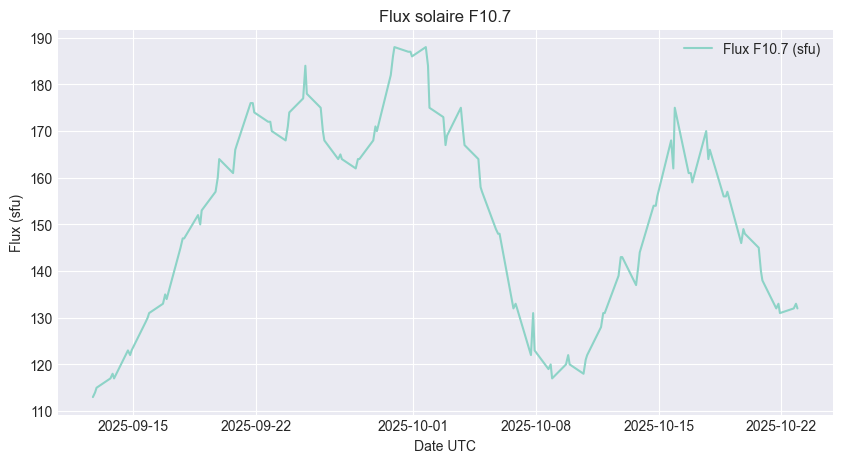

In [15]:
# --- 8. Flux solaire F10.7
flux_data = load_json(URLS["solar_flux"])
df_flux = pd.DataFrame(flux_data)

# Vérification de colonnes
print("\nColonnes flux solaire :", df_flux.columns.tolist())

# Conversion du temps et tri
time_col = "time_tag" if "time_tag" in df_flux.columns else "time_tag_str"
df_flux[time_col] = pd.to_datetime(df_flux[time_col])
df_flux = df_flux.sort_values(time_col)

# Visualisation flux solaire
plt.figure()
flux_col = [c for c in df_flux.columns if 'flux' in c.lower()][0]
plt.plot(df_flux[time_col], df_flux[flux_col], label="Flux F10.7 (sfu)")
plt.title("Flux solaire F10.7")
plt.xlabel("Date UTC")
plt.ylabel("Flux (sfu)")
plt.legend()
plt.show()


Fusionnes les deux séries temporelles (merge_asof) pour aligner dans le temps les mesures du flux solaire et de l’indice K.

Puis tu affiches un scatter plot :

Axe X → intensité du Soleil (F10.7)

Axe Y → activité géomagnétique sur Terre (K-index)

Ce graphe te montre la relation entre activité solaire et probabilité d’aurores.

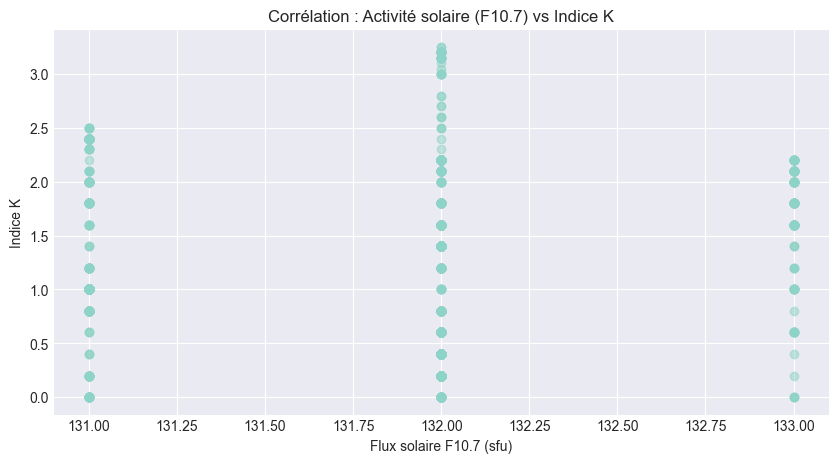

In [16]:
# --- 9. Corrélation activité solaire vs indice K
merged = pd.merge_asof(
    df_k.sort_values("time_tag"),
    df_flux.rename(columns={time_col: "time_tag"}).sort_values("time_tag"),
    on="time_tag"
)

plt.figure()
plt.scatter(merged[flux_col], merged[k_col], alpha=0.5)
plt.title("Corrélation : Activité solaire (F10.7) vs Indice K")
plt.xlabel("Flux solaire F10.7 (sfu)")
plt.ylabel("Indice K")
plt.show()

# Prochaines étapes

1- Dashboard Streamlit en temps réel

2- Alerte automatique : “Aurores possibles ce soir ? ”

3- Carte OVATION interactive (Mapbox / Folium)

4- Notifications (email)

